In [4]:
!pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.7 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pypfopt import expected_returns
from pypfopt import risk_models
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.sparse.linalg import eigsh
from pypfopt.efficient_frontier import EfficientFrontier
from google.colab import drive
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates
from sklearn.ensemble import RandomForestRegressor
import random
import xgboost as xgb

In [6]:
# Mount Google Drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/merged_data(2).csv")

Mounted at /content/drive


In [ ]:
## Process data

In [7]:
from numpy.core.multiarray import dtype
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)

In [8]:
def drop_problematic_rows(data, problem_value='#DIV/0!'):
    mask = (data == problem_value).any(axis=1)
    return data.loc[~mask]

# Assuming your dataframe is already loaded as 'data'
data_cleaned = drop_problematic_rows(data)

# Convert columns to float (except for 'Code')
for col in data_cleaned.columns:
    if col != 'Code':
        data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce', downcast='float')

# Ensure the 'Code' column is a string
data_cleaned['Code'] = data_cleaned['Code'].astype(str)
data = data_cleaned
del data_cleaned

<ipython-input-8-55a7391d2ac3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce', downcast='float')
<ipython-input-8-55a7391d2ac3>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned['Code'] = data_cleaned['Code'].astype(str)


In [9]:
print(f"This is all columns of my merged data: {data.columns}")
print(f"The data types are {data.dtypes}")

This is all columns of my merged data: Index(['Code', 'Close', 'High', 'Low', 'Volume', 'Market Cap', 'P/E', 'P/B',
       'Interest Rate %', 'Turnover %', 'beta',
       'U.S. Dollars to Euro Spot Exchange Rate', 'F-F_Mkt-RF', 'F-F_SMB',
       'F-F_HML', 'F-F_RF', 'Personal Consumption Expenditures ',
       'Long-Term Government Bond Yields: 10-year', 'Employment Rate',
       'FEDMIN', 'Consumer Price Index', 'Consumer Sentiment', 'M3', 'M1',
       'Total Credit to Private Non-Financial Sector',
       'Inflation Risk Premium', 'Retail Sales', 'FEDFUNDS',
       'Real Risk Premium', 'Unemployment Rate', 'Total Share Prices', 'GDP',
       'Private Final Consumption Expenditure', 'weekly real earnings',
       'weekly_returns', 'weekly_vol', 'annual_vol', 'Alpha', 'Sharpe',
       'Treynor', 'Jensen', 'MA_simple', 'MACD', 'KDJ', 'RSI', 'BOLL', 'ROE',
       'ROA', 'ROIC', 'net_sales', 'total_asset', 'current_ratio',
       'Quick Ratio', 'Shareholder's equity return ratio',
       

In [10]:
data.iloc[1,:]

Code                                                          AA
Close                                                  38.599998
High                                                       40.68
Low                                                    35.299999
Volume                                                31411014.0
Market Cap                                          7198551288.0
P/E                                                       33.173
P/B                                                       1.5915
Interest Rate %                                             2.19
Turnover %                                             16.843184
beta                                                    0.859061
U.S. Dollars to Euro Spot Exchange Rate                   1.1513
F-F_Mkt-RF                                                 -0.25
F-F_SMB                                                    -1.33
F-F_HML                                                     0.72
F-F_RF                   

In [11]:
#drop na
length_orig = len(data)
data.dropna(inplace=True)
length_now = len(data)
print(f"dropped {length_orig - length_now} rows")

dropped 0 rows


In [12]:
#filter abnormal returns out from sample

#drop na
data.dropna()

# Calculate Q1 and Q3
Q1 = data['weekly_returns'].quantile(0.25)
Q3 = data['weekly_returns'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

print(IQR)

# Define the threshold
threshold = 5 * IQR

# Filter out abnormal returns
filtered_data = data[(data['weekly_returns'] >= Q1 - threshold) & (data['weekly_returns'] <= Q3 + threshold)]

# Calculate the number of data points filtered out
filtered_out_data = len(data) - len(filtered_data)

# Print the result
print(f"Number of data points filtered out: {filtered_out_data}")

data = filtered_data

0.06523464620113373
Number of data points filtered out: 2772


In [ ]:
## define some optimize functions

In [13]:
from scipy.optimize import minimize

def mean_variance_optimization(window_data, top_stocks, risk_free_rate):
    stock_data = window_data[window_data['Code'].isin(top_stocks)]
    stock_returns = stock_data.pivot_table(values='weekly_returns', index=stock_data.index, columns='Code')
    #print(f"the pivit table of stock_returns is {stock_returns}")
    
    # Annualize the returns and covariance matrix
    annualized_returns = (1 + stock_returns).prod() ** (52 / len(stock_returns)) - 1
    annualized_cov_matrix = stock_returns.cov() * 52
    
    # Objective function: minimize the portfolio variance
    def objective_function(weights):
        return weights.T @ annualized_cov_matrix @ weights
    
    # Constraints: weights sum up to 1
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    
    # Bounds: weights between 0 and 1
    bounds = [(0, 0.5) for _ in range(len(top_stocks))]
    
    # Initial guess: equal weights
    initial_guess = np.array([1 / len(top_stocks)] * len(top_stocks))
    
    # Minimize the portfolio variance
    optimized_weights = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints).x
    
    # Calculate the optimized portfolio returns and volatility
    optimized_portfolio_returns = np.dot(annualized_returns, optimized_weights)
    optimized_portfolio_volatility = np.sqrt(optimized_weights.T @ annualized_cov_matrix @ optimized_weights)
    
    # Calculate the Sharpe ratio of the optimized portfolio
    optimized_sharpe_ratio = (optimized_portfolio_returns - risk_free_rate) / optimized_portfolio_volatility
    #print(f"the optimized weights are: {optimized_weights}")
    
    return optimized_weights


def calculate_pnl(top_stocks_data, stock_weights, top_stocks):
    pnl = 0
    for stock_code in top_stocks:
        stock_returns = top_stocks_data[top_stocks_data.Code == stock_code]['weekly_returns'].values
        #print(f"the stocks returns from pnl function for stock {stock_code} is : {stock_returns}")
        weight = stock_weights[stock_code]
        #print(f"with weights: {weight}")
        pnl += weight * np.sum(stock_returns)
    return pnl

In [14]:
## define some tuning method
from sklearn.model_selection import GridSearchCV
def tune_random_forest(X_train, y_train):
    # Number of trees in the random forest
    n_estimators = [5, 10, 20]
    # Maximum number of levels in each tree
    max_depth = [3, 5, None]

    # Create the grid
    grid = {'n_estimators': n_estimators,
            'max_depth': max_depth}

    # Use the grid to search for the best hyperparameters
    rf = RandomForestRegressor(random_state=42)
    rf_grid = GridSearchCV(estimator=rf, param_grid=grid,
                           cv=3, verbose=0, n_jobs=-1)
    rf_grid.fit(X_train, y_train)
    return rf_grid.best_estimator_


In [15]:
#define cluster-finding method (not use, too slow)
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, min_k, max_k):
    silhouette_scores = []

    for k in range(min_k, max_k + 1):
        kmeans = KMeans(n_clusters=k)
        clusters = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, clusters))

    # Find the optimal k value based on the highest silhouette score
    optimal_k = silhouette_scores.index(max(silhouette_scores)) + min_k
    return optimal_k

In [ ]:
## strategy, opt for VAR

In [16]:
 len(data.index.unique())

207

In [17]:
data.index.unique()

DatetimeIndex(['2018-10-19', '2018-10-26', '2018-11-02', '2018-11-09',
               '2018-11-16', '2018-11-23', '2018-11-30', '2018-12-07',
               '2018-12-14', '2018-12-21',
               ...
               '2022-08-19', '2022-08-26', '2022-09-02', '2022-09-09',
               '2022-09-16', '2022-09-23', '2022-09-30', '2022-10-07',
               '2022-10-14', '2022-10-21'],
              dtype='datetime64[ns]', name='Time', length=207, freq=None)

Processing dates 2018-10-19 00:00:00 to 2019-05-10 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 1761 stocks...
too few record for stock AFMD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock GLOB, not enough to train the model
too few record for stock GOGL, not enough to train the model
too few record for stock NETI, not enough to train the model
too few record for stock OEC, not enough to train the model
too few record for stock ORGO, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock PLM, not enough to train the model
too few record for stock SFL, not enough to train the model
too few record for stock SPNS, not enough to train the model
too few record for stock STNG, not enough to train the model
too few record for stock TGH, not enough to train the model
too few record for s

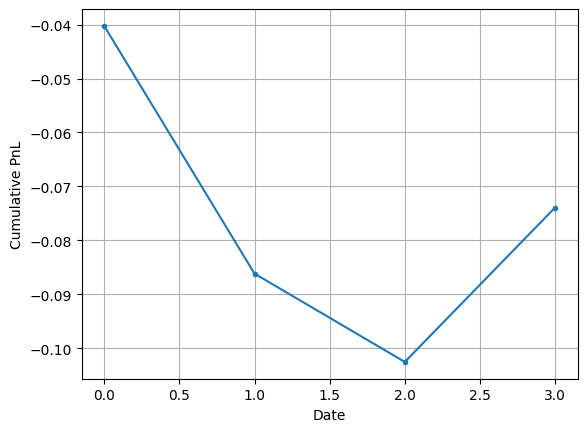

Processing dates 2018-11-16 00:00:00 to 2019-06-07 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 1142 stocks...
too few record for stock ASC, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock GOGL, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock NAT, not enough to train the model
too few record for stock NETI, not enough to train the model
too few record for stock NTB, not enough to train the model
too few record for stock OEC, not enough to train the model
too few record for stock PLM, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for stock SFL, not enough to train the model
too few record for stock SPNS, not enough to train the model
too few record for stoc

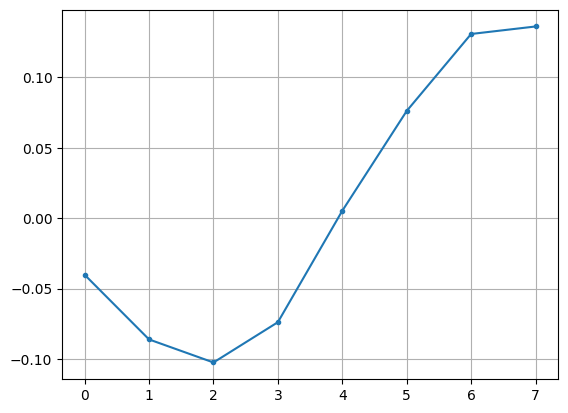

Processing dates 2018-12-14 00:00:00 to 2019-07-05 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 4 stocks...
too few stocks, skip this cluster
Cluster 3 has 2381 stocks...
too few record for stock AFMD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock ELF, not enough to train the model
too few record for stock FRO, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock GLOB, not enough to train the model
too few record for stock GOGL, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock NAT, not enough to train the model
too few record for stock NETI, not enough to train the model
too few record for sto

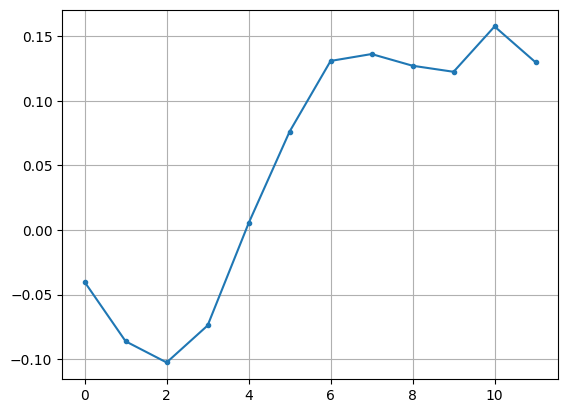

Processing dates 2019-01-11 00:00:00 to 2019-08-02 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2372 stocks...
too few record for stock CPA, not enough to train the model
too few record for stock ELF, not enough to train the model
too few record for stock FCEL, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for stock SPOT, not enough to train the model
too few record for stock WFRD, not enough to train the model
too few record for stock ZYXI, not enough to train the model
too few record for stock IBKR, not enough to train the model
too few record for stock ASLE, not enough to train the model
too few record for stock SWAV, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock FOX, not enough to train the model
too few record for s

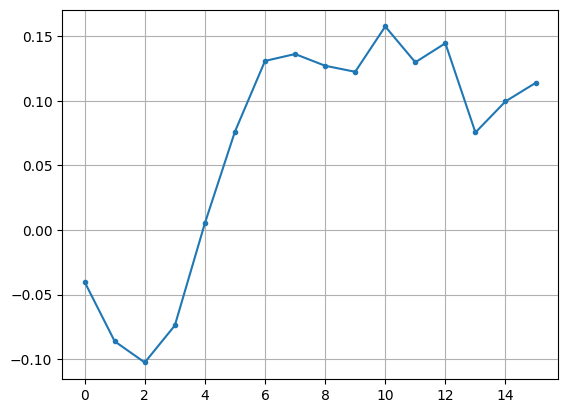

Processing dates 2019-02-08 00:00:00 to 2019-08-30 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2383 stocks...
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock ELF, not enough to train the model
too few record for stock FCEL, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for st

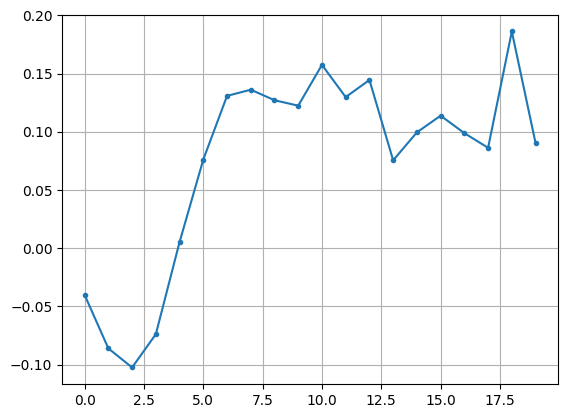

Processing dates 2019-03-08 00:00:00 to 2019-09-27 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2387 stocks...
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock ELF, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for stock SPOT, not enough to train the model
too few record for stock WFRD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for s

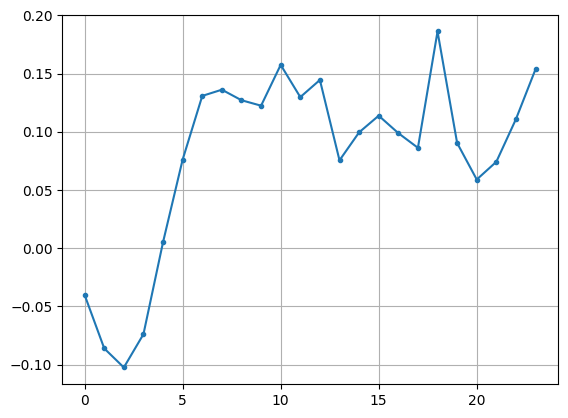

Processing dates 2019-04-05 00:00:00 to 2019-10-25 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2421 stocks...
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock WFRD, not enough to train the model
too few record for stock ALTG, not enough to train the model
too few record for stock RIDE, not enough to train the model
too few record for stock PSN, not enough to train the model
too few record for stock SPFI, not enough to train the model
too few record for stock UBER, not enough to train the model
too few record for stock AVTR, not enough to train the model
too few record f

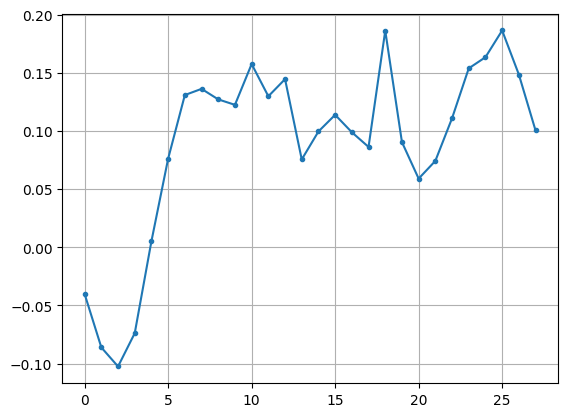

Processing dates 2019-05-03 00:00:00 to 2019-11-22 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2433 stocks...
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock CTLP, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock FCEL, not enough to train the model
too few record for stock TTSH, not enough to train the model
too few record for stock WFRD, not enough to train the model
too few record for stock RIDE, not enough to train the model
too few record for stock CLVT, not enough to train the model
too few record f

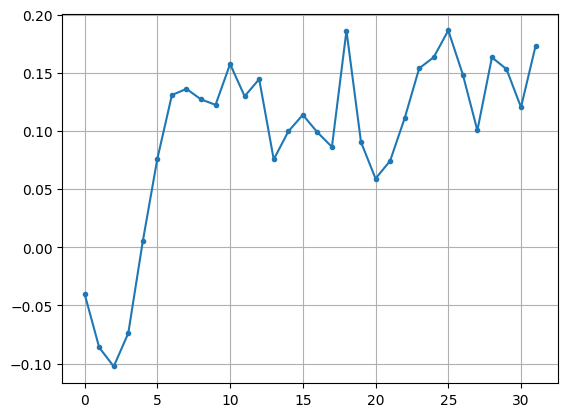

Processing dates 2019-05-31 00:00:00 to 2019-12-20 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 7 stocks...
too few stocks, skip this cluster
Cluster 1 has 2439 stocks...
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CLVT, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock CTLP, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock FCEL, not enough to train the model
too few record for stock TTSH, not enough to train the model
too few record for stock AMCR, not enough to train the model
too few record for stock IMVT, not enough to train the model
too few record f

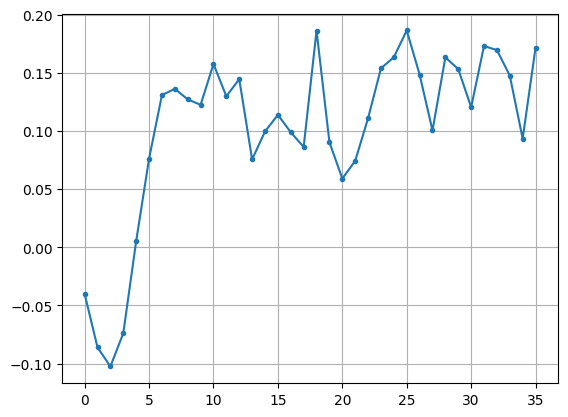

Processing dates 2019-06-28 00:00:00 to 2020-01-17 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2449 stocks...
too few record for stock AMCR, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock CLVT, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock CTLP, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock TTSH, not enough to train the model
too few record for stock IMVT, not enough to train the model
too few record for stock KRUS, not enough to train the model
too few record for stock BTRS, not enough to train the model
too few record 

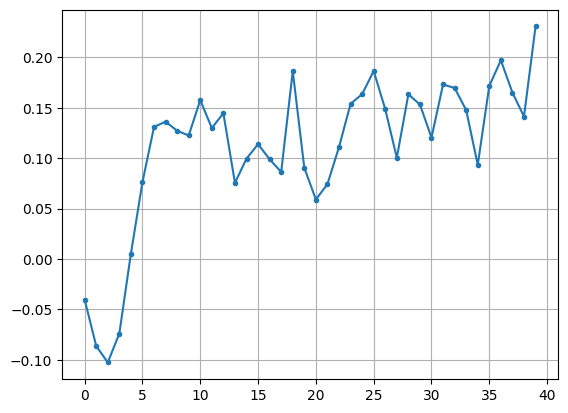

Processing dates 2019-07-26 00:00:00 to 2020-02-14 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2453 stocks...
too few record for stock BATL, not enough to train the model
too few record for stock CTLP, not enough to train the model
too few record for stock DO, not enough to train the model
too few record for stock IMVT, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock TTSH, not enough to train the model
too few record for stock RKLY, not enough to train the model
too few record for stock ALRS, not enough to train the model
too few record for stock HIMS, not enough to train the model
too few record for stock NET, not enough to train the model
too few record for stock SWTX, not enough to train the model
too few record for stock TXG, not enough to train the model
too few record for stock AFMD, not enough to train the model
too few record for stock AMCR, not enough to train the model
too few record fo

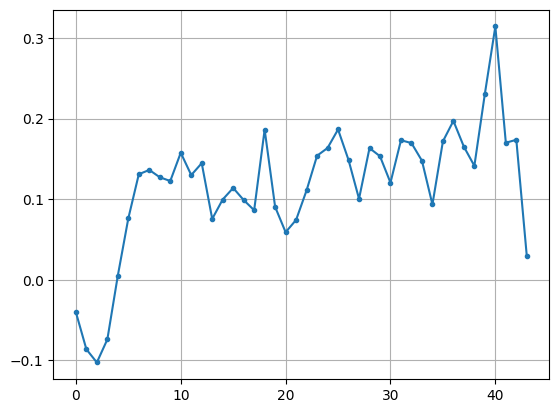

Processing dates 2019-08-23 00:00:00 to 2020-03-13 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2462 stocks...
too few record for stock CTLP, not enough to train the model
too few record for stock DO, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock TTSH, not enough to train the model
too few record for stock IMVT, not enough to train the model
too few record for stock AFMD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock BORR, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for

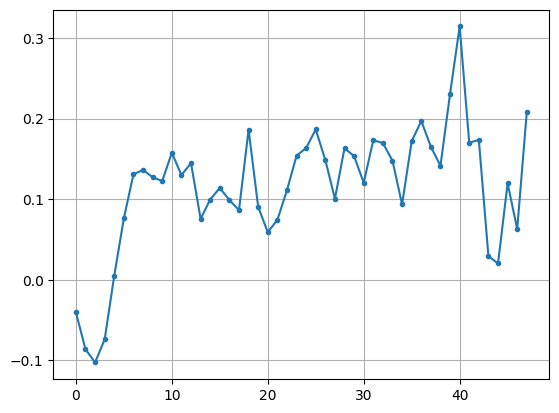

Processing dates 2019-09-20 00:00:00 to 2020-04-09 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 1669 stocks...
too few record for stock IMVT, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock AFMD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock GLOB, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock NAT, not enough to train the model
too few record for stock NETI, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for stock SFL, not enough to train the model
too few record for 

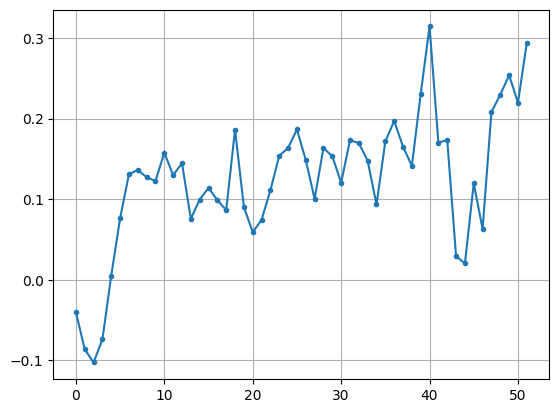

Processing dates 2019-10-18 00:00:00 to 2020-05-08 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 27 stocks...
too few stocks, skip this cluster
Cluster 2 has 10 stocks...
too few stocks, skip this cluster
Cluster 3 has 1918 stocks...
too few record for stock AFMD, not enough to train the model
too few record for stock ASC, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock BORR, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CSTE, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock DO, not enough to train the model
too few record for stock FLNG, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock GLOB, not enough to train the model
too few record for

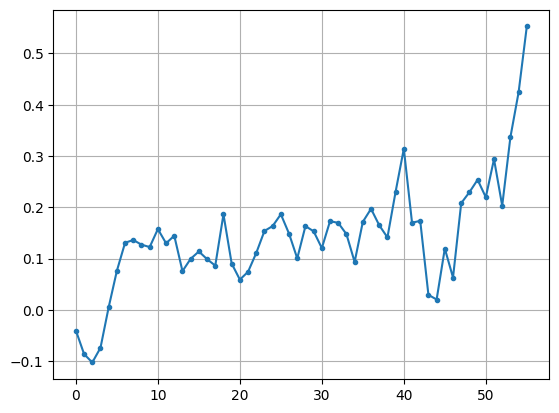

Processing dates 2019-11-15 00:00:00 to 2020-06-05 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 1832 stocks...
too few record for stock ASC, not enough to train the model
too few record for stock AUPH, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock BORR, not enough to train the model
too few record for stock CMRE, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CSTM, not enough to train the model
too few record for stock DHT, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock FLNG, not enough to train the model
too few record for stock FRO, not enough to train the model
too few record for stock GLOB, not enough to train the model
too few record for stock IGT, not enough to train the model
too few record for stock NAT, not enough to train the model
too few record for st

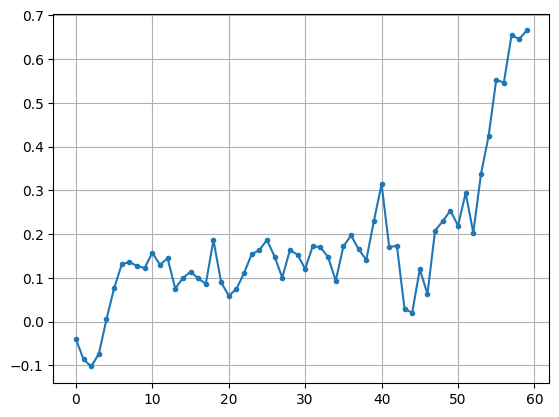

Processing dates 2019-12-13 00:00:00 to 2020-07-02 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 523 stocks...
too few record for stock CHK, not enough to train the model
too few record for stock GOGL, not enough to train the model
too few record for stock GREE, not enough to train the model
too few record for stock PLM, not enough to train the model
too few record for stock QGEN, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock CLSK, not enough to train the model
too few record for stock BEAM, not enough to train the model
too few record for stock MPLN, not enough to train the model
too few record for stock OTIS, not enough to train the model
too few record for stock RSI, not enough to train the model
too few record for stock SLQT, not enough to train the model
too few record for stock GBIO, not enough to train the model
too few record for stock RPRX, not enough to train the model
Selected 5 from e

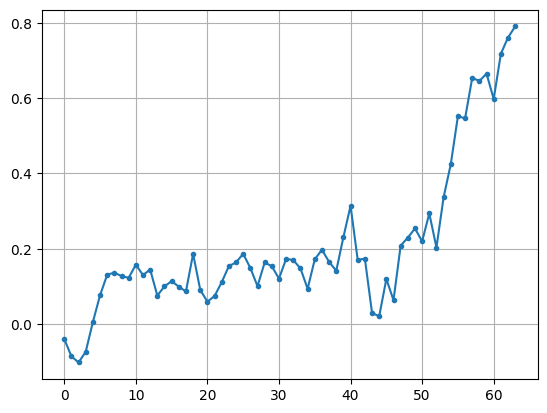

Processing dates 2020-01-10 00:00:00 to 2020-07-31 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 851 stocks...
too few record for stock CHK, not enough to train the model
too few record for stock CRC, not enough to train the model
too few record for stock NBR, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock VTOL, not enough to train the model
too few record for stock ARNC, not enough to train the model
too few record for stock OTIS, not enough to train the model
too few record for stock RSI, not enough to train the model
too few record for stock SKLZ, not enough to train the model
too few record for stock RPRX, not enough to train the model
too few record for stock MP, not enough to train the model
too few record for stock ACCD, not enough to train the model
Selected 8 from ensemble method in cluster 0
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 9 stocks...
too few stocks, skip this cluster
Cluster 3 has 0 stocks...
too few stoc

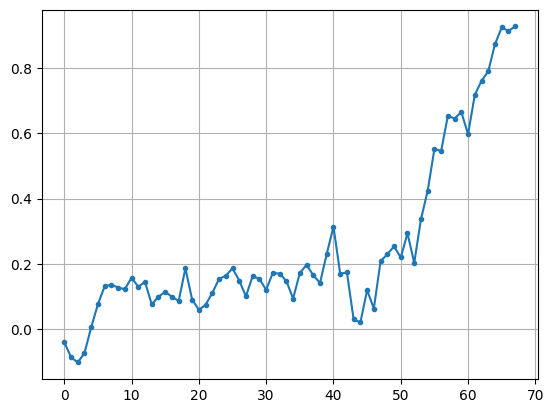

Processing dates 2020-02-07 00:00:00 to 2020-08-28 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 9 stocks...
too few stocks, skip this cluster
Cluster 1 has 2481 stocks...
too few record for stock BGFV, not enough to train the model
too few record for stock CHK, not enough to train the model
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock NBR, not enough to train the model
too few record for stock PRTY, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock VTOL, not enough to train the model
too few record for stock BATL, not enough to train the model
too few record for stock AEVA, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for s

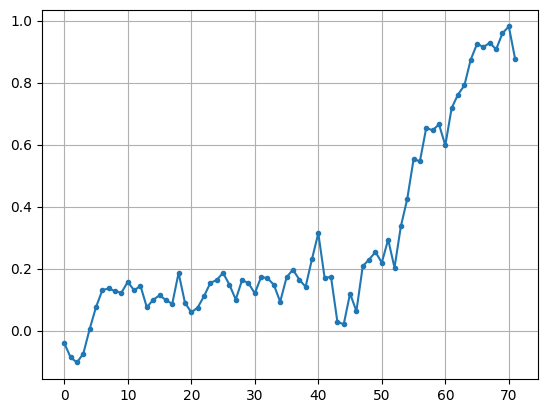

Processing dates 2020-03-06 00:00:00 to 2020-09-25 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2495 stocks...
too few record for stock BGFV, not enough to train the model
too few record for stock CHK, not enough to train the model
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock DOX, not enough to train the model
too few record for stock PRTY, not enough to train the model
too few record for stock VTOL, not enough to train the model
too few record for stock NBR, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock ARNC, not enough to train the model
too few record for stock KROS, not enough to train the model
too few record for stock RSI, not enough to train the model
too few record for stock APG, not enough to train the model
too few record for st

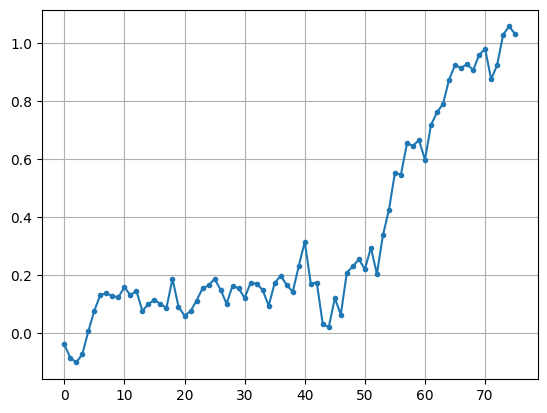

Processing dates 2020-04-03 00:00:00 to 2020-10-23 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 9 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2562 stocks...
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock PRTY, not enough to train the model
too few record for stock NARI, not enough to train the model
too few record for stock SLQT, not enough to train the model
too few record for stock TOI, not enough to train the model
too few record for stock DNMR, not enough to train the model
too few record for stock FOUR, not enough to train the model
too few record for stock ZI, not enough to train the model
too few record for stock APPH, not enough to train the model
too few record for st

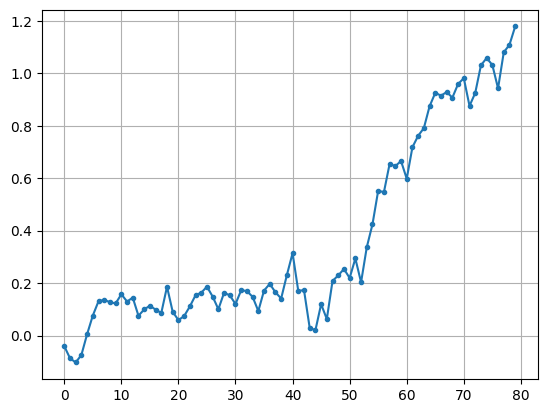

Processing dates 2020-05-01 00:00:00 to 2020-11-20 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2 stocks...
too few stocks, skip this cluster
Cluster 2 has 2587 stocks...
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock CHK, not enough to train the model
too few record for stock FOUR, not enough to train the model
too few record for stock ZI, not enough to train the model
too few record for stock APPH, not enough to train the model
too few record for stock AZEK, not enough to train the model
too few record for stock CLOV, not enough to train the model
too few record for sto

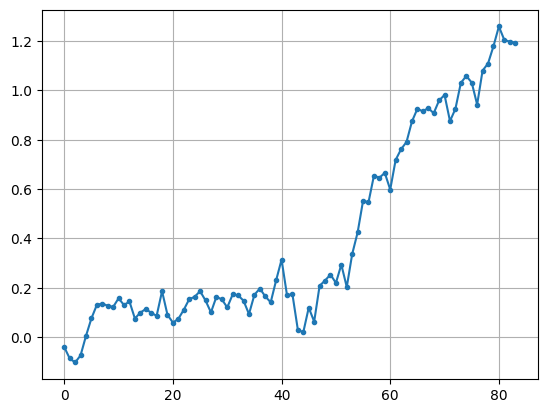

Processing dates 2020-05-29 00:00:00 to 2020-12-31 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2644 stocks...
too few record for stock CBL, not enough to train the model
too few record for stock CHK, not enough to train the model
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock VAL, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock ACCD, not enough to train the model
too few record for stock DNB, not enough to train the model
too few record for stock IAC, not enough to train the model
too few record for stock LMND, not enough to train the model
too few record for stock ZEV, not enough to train the model
too few record for stock CANO, not enough to train the model
too few record for sto

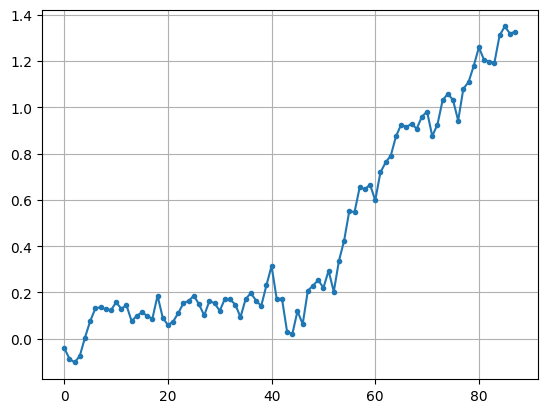

Processing dates 2020-06-26 00:00:00 to 2021-01-29 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 8 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 0 stocks...
too few stocks, skip this cluster
Cluster 3 has 2432 stocks...
too few record for stock CBL, not enough to train the model
too few record for stock CHK, not enough to train the model
too few record for stock CRC, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock TEAM, not enough to train the model
too few record for stock VAL, not enough to train the model
Selected 15 from ensemble method in cluster 3
Cluster 4 has 229 stocks...
too few record for stock ALVR, not enough to train the model
too few record for stock CERE, not enough to train the model
too few r

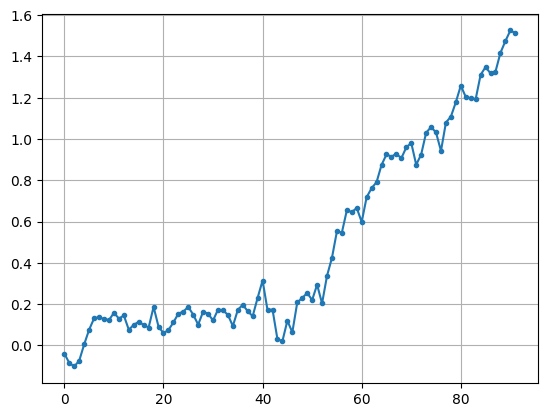

Processing dates 2020-07-24 00:00:00 to 2021-02-26 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2676 stocks...
too few record for stock CBL, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock DEN, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock ETWO, not enough to train the model
too few record for stock GME, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock REPX, not enough to train the model
too few record for stock RIOT, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock GLS, not enough to train the model
too few record for stock HPK, not enough to train the model
too few record for st

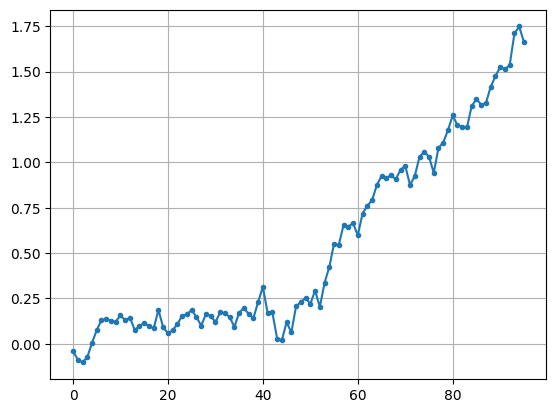

Processing dates 2020-08-21 00:00:00 to 2021-03-26 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2689 stocks...
too few record for stock CBL, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock ETWO, not enough to train the model
too few record for stock GME, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock REPX, not enough to train the model
too few record for stock RIOT, not enough to train the model
too few record for stock AFMD, not enough to train the model
too few record for stock BIPC, not enough to train the model
too few record for 

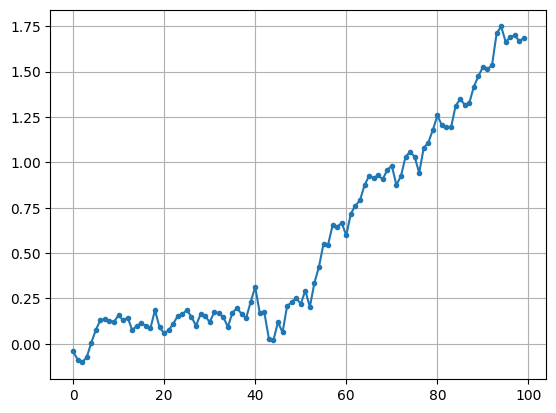

Processing dates 2020-09-18 00:00:00 to 2021-04-23 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 258 stocks...
too few record for stock ETWO, not enough to train the model
too few record for stock AMPS, not enough to train the model
Selected 2 from ensemble method in cluster 2
Cluster 3 has 8 stocks...
too few stocks, skip this cluster
Cluster 4 has 2462 stocks...
too few record for stock CBL, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock GPOR, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock REPX, not enough to train the model
too few record for stock RIOT, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few

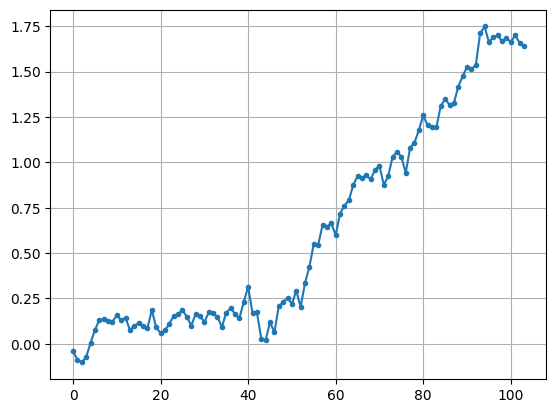

Processing dates 2020-10-16 00:00:00 to 2021-05-21 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 1401 stocks...
too few record for stock BLDE, not enough to train the model
too few record for stock CBL, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock ETWO, not enough to train the model
too few record for stock GREE, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for stock SB, not enough to train the model
too few record for stock SKIL, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock HLLY, not enough to train the model
too few record for stock PTRA, not enough to train the model
too few record for stock SKIN, not enough to train the model
too few record for stock CNXC, not enough to train the model
too few record for 

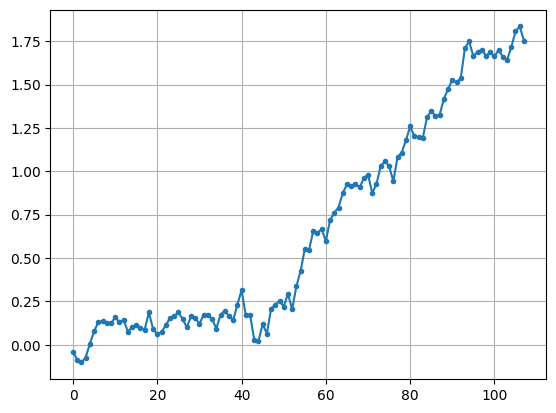

Processing dates 2020-11-13 00:00:00 to 2021-06-18 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 8 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2764 stocks...
too few record for stock AMC, not enough to train the model
too few record for stock ASO, not enough to train the model
too few record for stock BIPC, not enough to train the model
too few record for stock BLDE, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock ETWO, not enough to train the model
too few record for stock GREE, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for sto

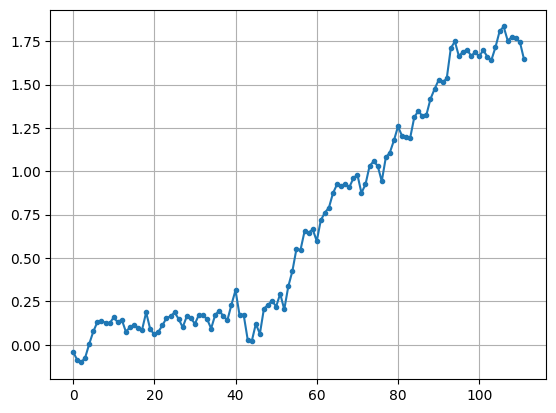

Processing dates 2020-12-18 00:00:00 to 2021-07-16 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2791 stocks...
too few record for stock AMC, not enough to train the model
too few record for stock ASO, not enough to train the model
too few record for stock BIPC, not enough to train the model
too few record for stock BLDE, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock ETWO, not enough to train the model
too few record for stock GREE, not enough to train the model
too few record for stock IBEX, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock PLL, not enough to train the model
too few record for sto

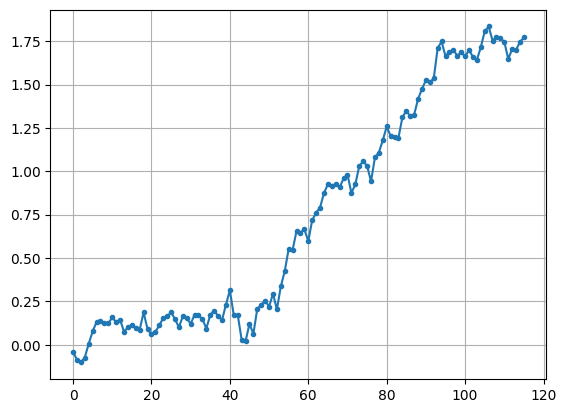

Processing dates 2021-01-22 00:00:00 to 2021-08-13 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 8 stocks...
too few stocks, skip this cluster
Cluster 3 has 2815 stocks...
too few record for stock BLDE, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock SKIL, not enough to train the model
too few record for stock AMC, not enough to train the model
too few record for stock BHIL, not enough to train the model
too few record for stock DM, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock BRDS, not enough to train the model
too few record for st

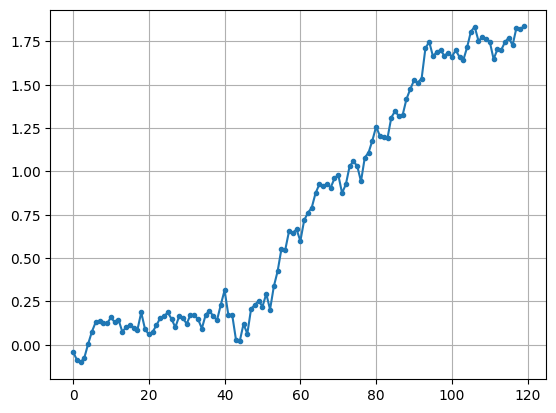

Processing dates 2021-02-19 00:00:00 to 2021-09-10 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2819 stocks...
too few record for stock BLDE, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock SKIL, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock GREE, not enough to train the model
too few record for stock PCT, not enough to train the model
too few record for stock ACVA, not enough to train the model
too few record for stock ALHC, not enough to train the model
too few record for stock CPTN, not enough to train the model
too few record for

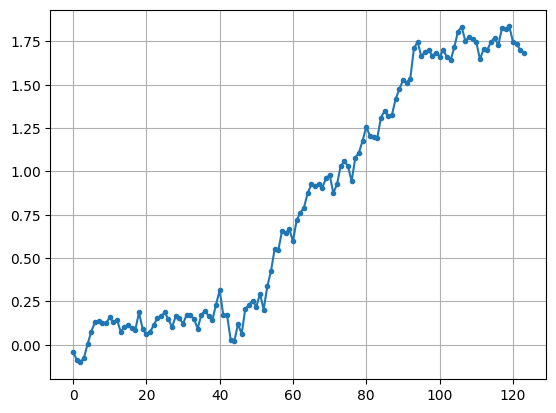

Processing dates 2021-03-19 00:00:00 to 2021-10-08 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2733 stocks...
too few record for stock BLDE, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock SKIL, not enough to train the model
too few record for stock AKYA, not enough to train the model
too few record for stock TSP, not enough to train the model
too few record for stock ADTH, not enough to train the model
too few record for stock AGTI, not enough to train the model
too few record for stock DNA, not enough to train the model
too few record for stock DV, not enough to train the model
too few record for s

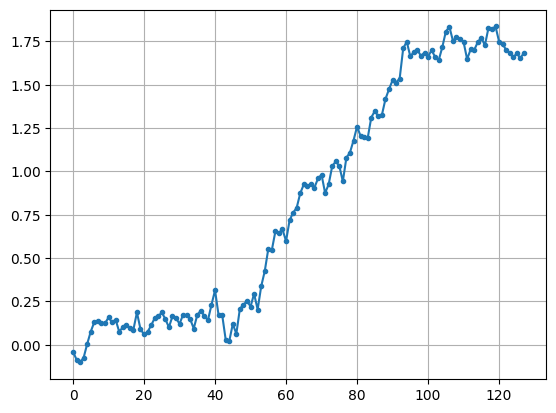

Processing dates 2021-04-16 00:00:00 to 2021-11-05 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2865 stocks...
too few record for stock BODY, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock VERA, not enough to train the model
too few record for stock PCOR, not enough to train the model
too few record for stock SLDP, not enough to train the model
too few record for stock SQSP, not enough to train the model
too few record for stock DAWN, not enough to train the model
too few record for stock FIGS, not enough to train the model
too few record for stock FLYW, not enough to train the model
too few record f

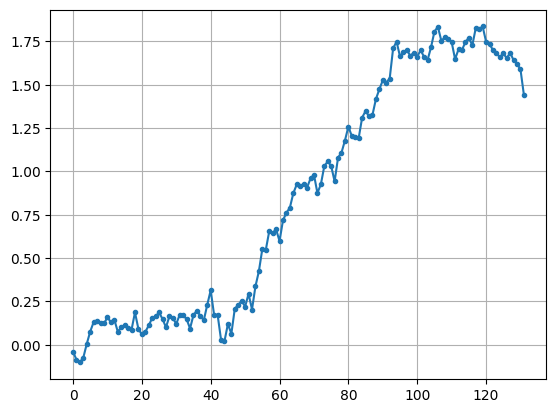

Processing dates 2021-05-14 00:00:00 to 2021-12-03 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2892 stocks...
too few record for stock BODY, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock LFST, not enough to train the model
too few record for stock ZETA, not enough to train the model
too few record for stock AOMR, not enough to train the model
too few record for stock BARK, not enough to train the model
too few record for stock BLDE, not enough to train the model
too few record for stock IPSC, not enough to train the model
too few record for stock JOAN, not enough to train the model
too few record for stock LYEL, not enough to train the model
too few record 

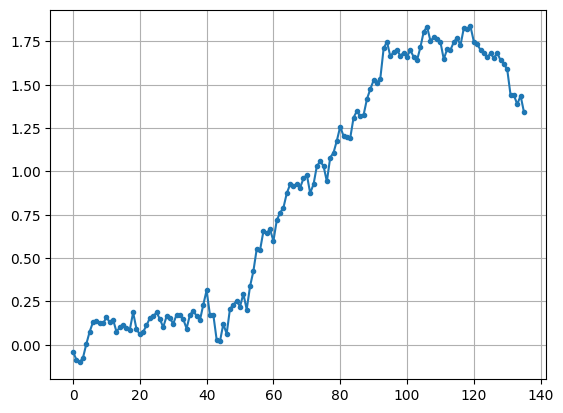

Processing dates 2021-06-11 00:00:00 to 2022-01-07 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 7 stocks...
too few stocks, skip this cluster
Cluster 2 has 1 stocks...
too few stocks, skip this cluster
Cluster 3 has 0 stocks...
too few stocks, skip this cluster
Cluster 4 has 2896 stocks...
too few record for stock BODY, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock IRNT, not enough to train the model
too few record for stock MULN, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock RSVR, not enough to train the model
too few record for stock BLFY, not enough to train the model
too few record for stock BLND, not enough to train the model
too few record for stock ERAS, not enough to train the model
too few record for stock FXLV, not enough to train the model
too few record for 

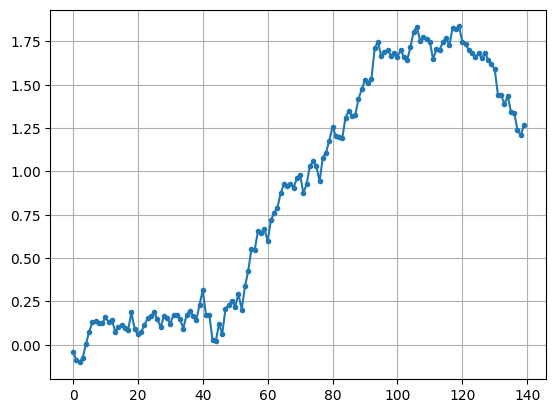

Processing dates 2021-07-09 00:00:00 to 2022-02-04 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 2899 stocks...
too few record for stock BOWL, not enough to train the model
too few record for stock BYSI, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock IVVD, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock DXLG, not enough to train the model
too few record for stock FCUV, not enough to train the model
too few record for stock INST, not enough to train the model
too few record for stock LWLG, not enough to train the model
too few record for stock ACT, not enough to train the model
too few record for stock BASE, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for stock CMP, not enough to train the model
too few record for stock CNM, not enough to train the model
too few record for 

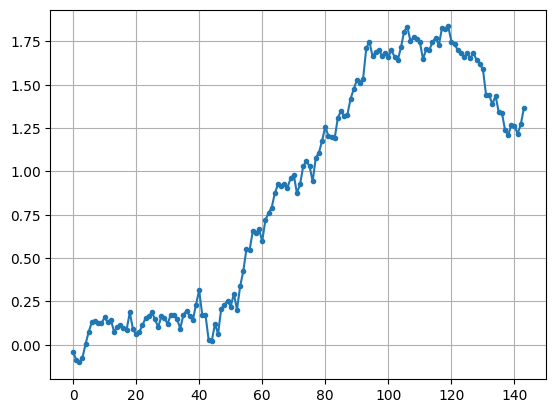

Processing dates 2021-08-06 00:00:00 to 2022-03-04 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 8 stocks...
too few stocks, skip this cluster
Cluster 2 has 2901 stocks...
too few record for stock BIPC, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock UA, not enough to train the model
too few record for stock UAA, not enough to train the model
too few record for stock ZGN, not enough to train the model
too few record for stock BYSI, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock FCUV, not enough to train the model
too few record for stock LWLG, not enough to train the model
too few record for stock ACT, not enough to train the model
too few record for stock BASE, not enough to train the model
too few record for stock BLX, not enough to train the model
too few record for sto

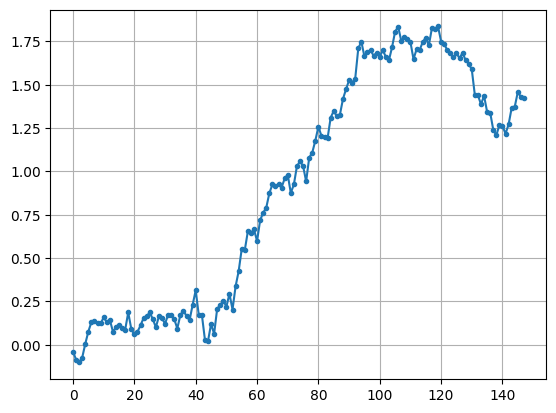

Processing dates 2021-09-03 00:00:00 to 2022-04-01 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 5 stocks...
too few stocks, skip this cluster
Cluster 3 has 8 stocks...
too few stocks, skip this cluster
Cluster 4 has 2903 stocks...
too few record for stock BIPC, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock BYSI, not enough to train the model
too few record for stock PL, not enough to train the model
too few record for stock UA, not enough to train the model
too few record for stock UAA, not enough to train the model
too few record for stock ZGN, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock CURV, not enough to train the model
too few record for stock MSGE, not enough to train the model
too few record for stock

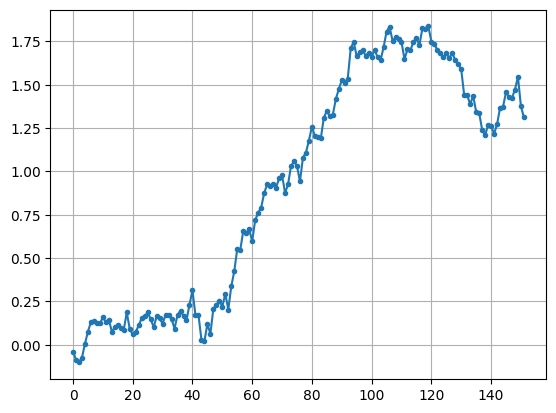

Processing dates 2021-10-01 00:00:00 to 2022-04-29 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 716 stocks...
too few record for stock BODY, not enough to train the model
too few record for stock CURV, not enough to train the model
too few record for stock MSGE, not enough to train the model
too few record for stock HTZ, not enough to train the model
too few record for stock TSVT, not enough to train the model
too few record for stock PRM, not enough to train the model
too few record for stock USER, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock CISO, not enough to train the model
too few record for stock TGAN, not enough to train the model
too few record for stock BOWL, not enough to train the model
too few record for stock FEAM, not enough to train the model
too few record for stock APLD, not enough to train the model
too few record for stock CRGE, not enough to train the model
Selected 7 from en

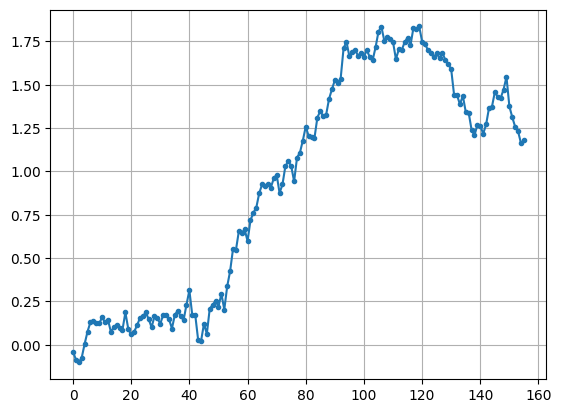

Processing dates 2021-10-29 00:00:00 to 2022-05-27 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 1734 stocks...
too few record for stock BIPC, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock MSGE, not enough to train the model
too few record for stock UA, not enough to train the model
too few record for stock UAA, not enough to train the model
too few record for stock ZGN, not enough to train the model
too few record for stock RENT, not enough to train the model
too few record for stock KD, not enough to train the model
too few record for stock APO, not enough to train the model
too few record for stock CHPT, not enough to train the model
too few record for stock ME, not enough to train the model
too few record for stock DOUG, not enough to train the model
too few record for stock AMLX, not enough to train the model
too few record for stock

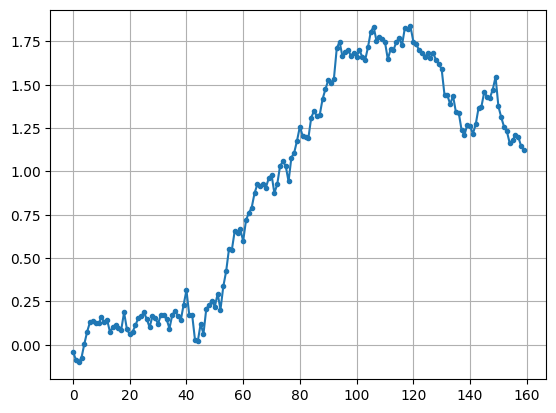

Processing dates 2021-11-26 00:00:00 to 2022-06-24 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 2920 stocks...
too few record for stock BIPC, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock BYSI, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock CURV, not enough to train the model
too few record for stock KD, not enough to train the model
too few record for stock LTCH, not enough to train the model
too few record for stock MSGE, not enough to train the model
too few record for stock RENT, not enough to train the model
too few record for stock UA, not enough to train the model
too few record for stock UAA, not enough to train the model
too few record for stock ZGN, not enough to train the model
too few record for stock AMLX, not enough to train the model
too few record for stock CINC, not enough to train the model
too few record for stock CISO, not enough to train the model
too few record for s

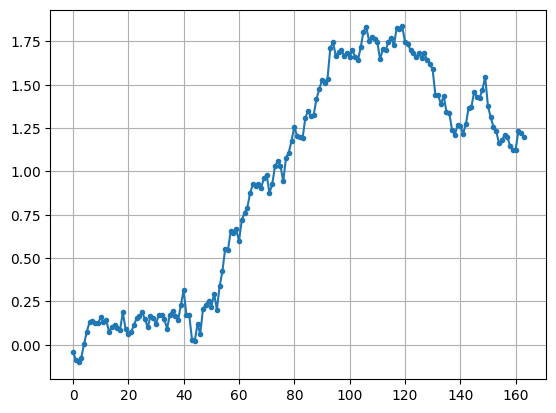

Processing dates 2021-12-23 00:00:00 to 2022-07-22 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 2923 stocks...
too few record for stock BIPC, not enough to train the model
too few record for stock BODY, not enough to train the model
too few record for stock BYSI, not enough to train the model
too few record for stock CR, not enough to train the model
too few record for stock CURV, not enough to train the model
too few record for stock KD, not enough to train the model
too few record for stock LTCH, not enough to train the model
too few record for stock MSGE, not enough to train the model
too few record for stock RENT, not enough to train the model
too few record for stock UA, not enough to train the model
too few record for stock UAA, not enough to train the model
too few record for stock ZGN, not enough to train the model
too few record for stock ACLX, not enough to train the model
too few record for sto

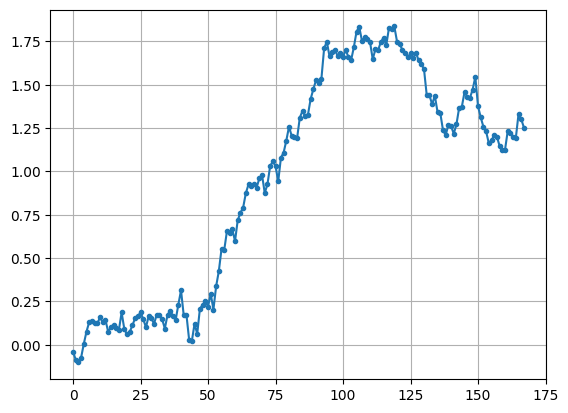

Processing dates 2022-01-28 00:00:00 to 2022-08-19 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 0 stocks...
too few stocks, skip this cluster
Cluster 3 has 2918 stocks...
too few record for stock AVYA, not enough to train the model
too few record for stock BORR, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CVET, not enough to train the model
too few record for stock CYBE, not enough to train the model
too few record for stock GAMB, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock LTCH, not enough to train the model
too few record for stock PZN, not enough to train the model
too few record for stock STON, not enough to train the model
too few record for stock TSP, not enough to train the model
too few record for stock TWTR, not enough to train the model
too few record for

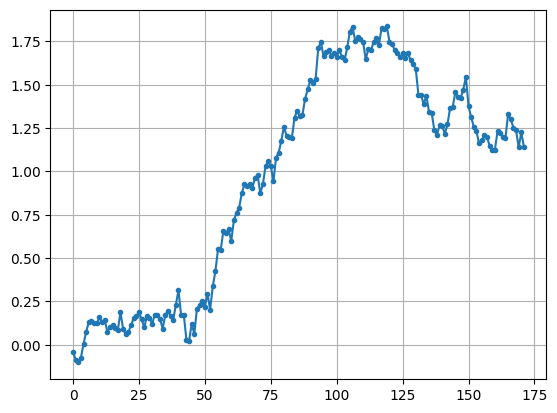

Processing dates 2022-02-25 00:00:00 to 2022-09-16 00:00:00...
Performing PCA and Kmeans


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Clustering with total 5 clusters
Cluster 0 has 0 stocks...
too few stocks, skip this cluster
Cluster 1 has 0 stocks...
too few stocks, skip this cluster
Cluster 2 has 0 stocks...
too few stocks, skip this cluster
Cluster 3 has 2916 stocks...
too few record for stock AVYA, not enough to train the model
too few record for stock BORR, not enough to train the model
too few record for stock CPA, not enough to train the model
too few record for stock CVET, not enough to train the model
too few record for stock CYBE, not enough to train the model
too few record for stock GAMB, not enough to train the model
too few record for stock GLNG, not enough to train the model
too few record for stock LTCH, not enough to train the model
too few record for stock PZN, not enough to train the model
too few record for stock STON, not enough to train the model
too few record for stock TSP, not enough to train the model
too few record for stock TWTR, not enough to train the model
too few record for

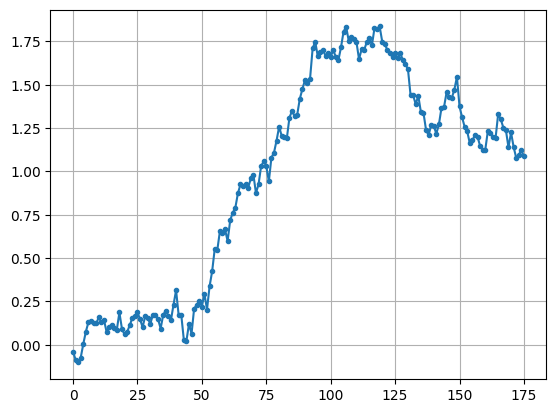

the portfolio change 2.125680096246161


In [18]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

def rolling_window_analysis3(data, window_size=12):
    unique_dates = data.index.unique()
    pnls = []

    # Initialize the plot
    plt.figure()
    plt.xlabel('Date')
    plt.ylabel('Cumulative PnL')

    for i in range(0, len(unique_dates) - window_size - 4, 4):
        print(f"Processing dates {unique_dates[i]} to {unique_dates[i+window_size-1]}...")
        window_data = data.loc[unique_dates[i]:unique_dates[i+window_size-1]]
        stocks = window_data['Code'].unique()

        # Perform PCA and k-means clustering
        print(f"Performing PCA and Kmeans")

        #Scale the data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(window_data.drop(['Code', 'Close', 'weekly_returns'], axis=1))

        pca = PCA(n_components=5) # Adjust the number of components as needed
        X = pca.fit_transform(scaled_data)
        kmeans = KMeans(n_clusters=5) # Adjust the number of clusters as needed
        clusters = kmeans.fit_predict(X)
        
        # Perform linear regression on each cluster & RF
        top_stocks = []

        print(f"Processing Clustering with total {kmeans.n_clusters} clusters")
        for cluster in range(kmeans.n_clusters):
            
            cluster_stocks = [stocks[i] for i in range(len(stocks)) if clusters[i] == cluster] # Fix the issue here
            print(f"Cluster {cluster} has {len(cluster_stocks)} stocks...")

            if len(cluster_stocks) <= window_size:
              print(f"too few stocks, skip this cluster")
              continue

            stock_returns_ensemble = []

            
            for stock in cluster_stocks:
                stock_data = window_data[window_data['Code'] == stock]
                #print(f"There are {len(stock_data)} records related to this stock")
                if len(stock_data) < window_size-6:
                  print(f"too few record for stock {stock}, not enough to train the model")
                  continue

                stock_data_scaled = scaler.transform(stock_data.drop(['Code', 'Close', 'weekly_returns'], axis=1))
                stock_data_pca = pca.transform(stock_data_scaled)
                
                # Use previous 9 weeks to fit the model and test on the next 3 weeks
                X_train, y_train = stock_data_pca[:-6], stock_data['weekly_returns'][:-6]
                X_test, y_test = stock_data_pca[-6:], stock_data['weekly_returns'][-6:]
                
                if len(X_train) > 1:
                    # Check if training data is not empty
                    model_ridge = Ridge()
                    params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
                    grid_search = GridSearchCV(model_ridge, param_grid=params, cv=5)
                    grid_search.fit(X_train, y_train)
                    preds_ridge = grid_search.predict(X_test)

                    model_rf = RandomForestRegressor(n_estimators=50, random_state=10)
                    model_rf.fit(X_train, y_train)
                    preds_rf = model_rf.predict(X_test)

                    # Calculate the average predicted return for the next 3 weeks
                    ensemble_preds = 0.7 * preds_ridge + 0.3 * preds_rf
                    ensemble_predicted_return = np.mean(ensemble_preds) if len(ensemble_preds) > 0 else 0


                else:
                  ensemble_predicted_return = 0

                stock_returns_ensemble.append((stock, ensemble_predicted_return))

            stock_returns_ensemble.sort(key=lambda x: x[1], reverse=True)
          
            top_stocks_cluster = [stock for stock, predicted_return in stock_returns_ensemble[:min(int(len(stock_returns_ensemble) * 0.01), 15)]]
            print(f"Selected {len(top_stocks_cluster)} from ensemble method in cluster {cluster}")
            top_stocks += top_stocks_cluster

        if len(top_stocks) > 15:
          top_stocks = top_stocks[:15]  

        # Perform mean-variance optimization with constraints
        risk_free_rate = window_data['Interest Rate %'].iloc[-1]/252 # assuming weekly risk-free rate
        print(f"optimizing weights for the portfolio now...")
        optimized_weights = mean_variance_optimization(window_data, top_stocks, risk_free_rate)
        stock_weights = dict(zip(top_stocks, optimized_weights))
        

        # Print the top 5 stocks and their positions in the portfolio
        top_5_stocks = sorted(stock_weights.items(), key=lambda x: x[1], reverse=True)[:5]
        for stock, weight in top_5_stocks:
          print(f"  {stock}: {weight:.3f}")
        
        # Calculate PnL for the next 4 weeks
        print(f"now calculating the pnl for next 4 week before we rebalance next time...")
        for j in range(4):
          next_week_data = data.loc[unique_dates[i+window_size+j]:unique_dates[i+window_size+j]]
          
          top_stocks_next_week_data = next_week_data[next_week_data['Code'].isin(top_stocks)]
          #print(top_stocks_next_week_data['weekly_returns'])

          pnl = calculate_pnl(top_stocks_next_week_data, stock_weights, top_stocks)
          print(f"the PnL in the week: {unique_dates[i+window_size+j]} is  {pnl}")
          pnls.append(pnl)

        # Update the plot with the new PnL
        plt.plot(np.cumsum(pnls), marker='o', linestyle='-', markersize=3)
        plt.grid()
      
        plt.pause(0.1)  # Pause for a short time to let the plot update
        
      
    plt.show()
    print(f"the portfolio change {np.prod(1+ np.array(pnls))}")
    return pnls


pnl_from_minvar = rolling_window_analysis3(data, window_size=30)